The likelyhood of getting diabetes is altered by a number of factors including:

- Age
- Ethnicity
- Family History
- Weight
- Physical Inactivity
- Genetics
- Other Conditions: High blood pressure, high cholesterol, and heart disease increase the risk

To explore this data I will be using synthetic patients records from [SynthericMass](https://synthea.mitre.org/) using a community version of a FHIR enabled Data Platform from Intersystems called IRIS [Intersystems Open Exchange - iris-fhir-template](https://openexchange.intersystems.com/package/iris-fhir-template).
These examples are based on US population demographics and will also use a mix of LOINC and SNOMED coding, so codes used are likely to differ from UK based systems which predominantly use SNOMED CT UK Edition.

In [69]:
import iris
import pandas as pd

host = "localhost"
# this is the superserver port
port = 32782
namespace = "FHIRSERVER"
user = "_SYSTEM"
password = "SYS"

conn = iris.connect(
    hostname=host,
    port=port,
    namespace=namespace,
    username=user,
    password=password
)

# create a cursor
cursor = conn.cursor()

sql = """
      select patient._id, patient.KEY, DATEDIFF('year',birthdate,$HOROLOG) as AGE,
             gender,
             case gender
                 when 'male' then 1
                 when 'female' then 2
                 when 'other' then 0
                 else 9
                 end as genderUK,
             IFNULL(diabetes._id,0,1) as TYPE2DIABETES,
             IFNULL(hypertension._id,0,1) as HYPERTENSION,
          IFNULL(diabetes._id,-1,DATEDIFF('year',diabetes.onsetDateStart,birthdate)) as TYPE2DIABETES_AGE,
          IFNULL(hypertension._id,-1,DATEDIFF('year',hypertension.onsetDateStart,birthdate)) as HYPERTENSION_AGE
      from HSFHIR_X0001_S.Patient patient
       left outer join HSFHIR_X0001_S.Condition diabetes on patient.Key = diabetes.patient and diabetes.code [ '44054006'
       left outer join HSFHIR_X0001_S.Condition hypertension on patient.Key = hypertension.patient and hypertension.code [ '59621000'
      """

cursor.execute(sql)
data = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(data, columns=column_names)
pd.set_option('future.no_silent_downcasting', True)
df['TYPE2DIABETES_AGE'] = df['TYPE2DIABETES_AGE'].replace(-1, pd.NA).fillna(0).astype(int)
df['HYPERTENSION_AGE'] = df['HYPERTENSION_AGE'].replace(-1, pd.NA).fillna(0).astype(int)
print(df.describe())

               AGE     genderUK  TYPE2DIABETES  HYPERTENSION  \
count  2387.000000  2387.000000    2387.000000   2387.000000   
mean     47.628404     1.501466       0.068705      0.250524   
std      27.336157     0.500103       0.253006      0.433405   
min       0.000000     1.000000       0.000000      0.000000   
25%      25.000000     1.000000       0.000000      0.000000   
50%      48.000000     2.000000       0.000000      0.000000   
75%      67.000000     2.000000       0.000000      1.000000   
max     111.000000     2.000000       1.000000      1.000000   

       TYPE2DIABETES_AGE  HYPERTENSION_AGE  
count        2387.000000       2387.000000  
mean            4.038123         17.074152  
std            15.902463         31.638808  
min             0.000000          0.000000  
25%             0.000000          0.000000  
50%             0.000000          0.000000  
75%             0.000000         14.000000  
max           100.000000        106.000000  


Some of the values in the last section are wrong or nonsense, I will correct that later.

The mean AGE values are correct. This is visible in the diagram below.

gender
female    Axes(0.125,0.11;0.775x0.77)
male      Axes(0.125,0.11;0.775x0.77)
Name: AGE, dtype: object

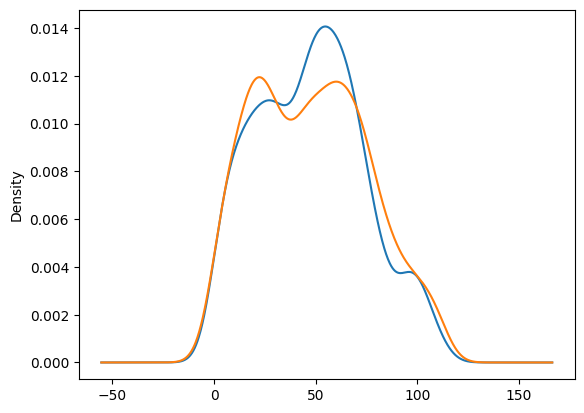

In [71]:
df.groupby('gender').AGE.plot(kind='kde')

gender
female    Axes(0.125,0.11;0.775x0.77)
male      Axes(0.125,0.11;0.775x0.77)
Name: AGE, dtype: object

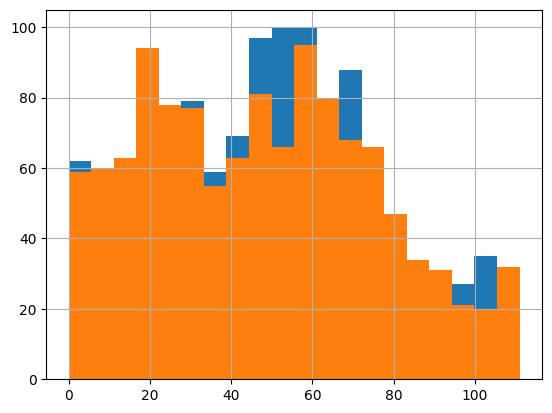

In [46]:
df.groupby('gender').AGE.hist(stacked=False, bins=20)

TYPE2DIABETES

              AGE    genderUK  TYPE2DIABETES  HYPERTENSION  TYPE2DIABETES_AGE  \
count  164.000000  164.000000          164.0    164.000000         164.000000   
mean    66.225610    1.445122            1.0      0.573171          58.774390   
std     21.562956    0.498501            0.0      0.496132          21.562956   
min     25.000000    1.000000            1.0      0.000000          14.000000   
25%     50.000000    1.000000            1.0      0.000000          44.750000   
50%     62.000000    1.000000            1.0      1.000000          63.000000   
75%     80.250000    2.000000            1.0      1.000000          75.000000   
max    111.000000    2.000000            1.0      1.000000         100.000000   

       HYPERTENSION_AGE  
count        164.000000  
mean          34.060976  
std           33.779453  
min            0.000000  
25%            0.000000  
50%           26.500000  
75%           65.000000  
max          100.000000  


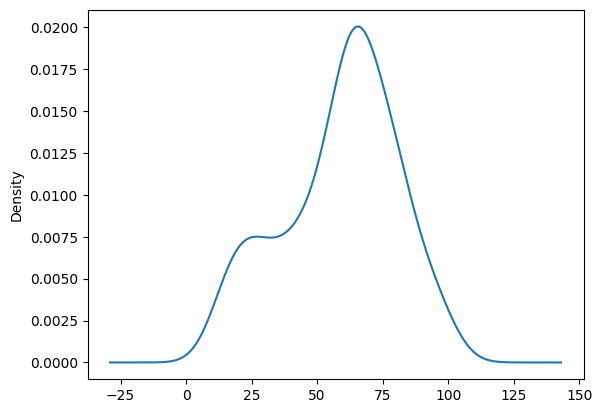

In [75]:
dfDiabetes = df[df.TYPE2DIABETES == 1].copy()
dfDiabetes.groupby('TYPE2DIABETES').TYPE2DIABETES_AGE.plot(kind='kde')

print(dfDiabetes.describe())

              AGE    genderUK  TYPE2DIABETES  HYPERTENSION  TYPE2DIABETES_AGE  \
count  598.000000  598.000000     598.000000         598.0         598.000000   
mean    56.846154    1.498328       0.157191           1.0           9.341137   
std     22.662621    0.500416       0.364285           0.0          23.298960   
min     19.000000    1.000000       0.000000           1.0           0.000000   
25%     40.250000    1.000000       0.000000           1.0           0.000000   
50%     56.000000    1.000000       0.000000           1.0           0.000000   
75%     71.000000    2.000000       0.000000           1.0           0.000000   
max    111.000000    2.000000       1.000000           1.0         100.000000   

       HYPERTENSION_AGE  
count        598.000000  
mean          68.153846  
std           22.662621  
min           14.000000  
25%           54.000000  
50%           69.000000  
75%           84.750000  
max          106.000000  


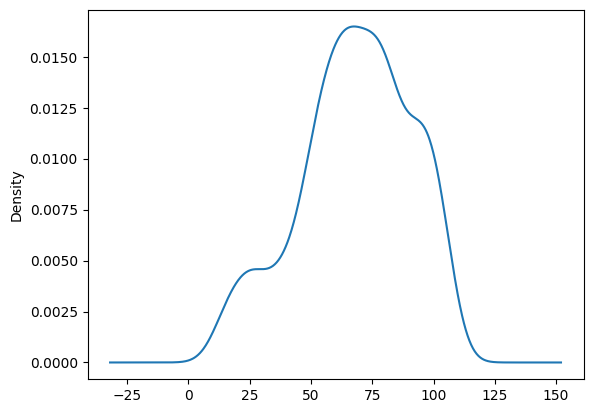

In [77]:
dfHypertension = df[df.HYPERTENSION == 1].copy()
dfHypertension.groupby('HYPERTENSION').HYPERTENSION_AGE.plot(kind='kde')

print(dfHypertension.describe())